<a href="https://colab.research.google.com/github/nivesh48/Cifar-functional-classification-model/blob/master/cifar_functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary Pkgs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Loading Training and Testing Data,
Converting Labels into Categorical.

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)
y_test[7]

170500096/170498071 [==============================] - 6s 0us/step


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Normalizing the pixel values.

In [0]:
x_train,x_test=x_train/255.0,x_test/255.0

Model architecture and Data augmentation.

In [0]:
lam=1e-4
input_img=keras.Input(shape=(32,32,3))
conv3_1=layers.Conv2D(16,(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.l2(lam),activation='relu')(input_img)
conv5_1=layers.Conv2D(16,(5,5),padding='same',kernel_regularizer=tf.keras.regularizers.l2(lam),activation='relu')(input_img)
conc_1=tf.concat([conv3_1,conv5_1],axis=-1)
max_pool1=layers.MaxPool2D((2,2))(conc_1)
max_pool1=layers.BatchNormalization()(max_pool1)#
max_pool1=layers.Dropout(0.2)(max_pool1)#dropout
conv3_2=layers.Conv2D(32,(3,3),padding='same',kernel_regularizer=tf.keras.regularizers.l2(lam),activation='relu')(max_pool1)
conv5_2=layers.Conv2D(32,(5,5),padding='same',kernel_regularizer=tf.keras.regularizers.l2(lam),activation='relu')(max_pool1)
conc_2=tf.concat([conv3_2,conv5_2],axis=-1)
max_pool2=layers.MaxPool2D((2,2))(conc_2)
max_pool2=layers.BatchNormalization()(max_pool2)#
max_pool2=layers.Dropout(0.2)(max_pool2)#
conv_128=layers.Conv2D(128,(3,3),padding='same',activation='relu')(max_pool2)
max_pool3=layers.MaxPool2D((2,2))(conv_128)
max_pool3=layers.BatchNormalization()(max_pool3)#
max_pool3=layers.Dropout(0.3)(max_pool3)#
conv_256=layers.Conv2D(256,(3,3),padding='same',activation='relu')(max_pool3)
max_pool4=layers.MaxPool2D((2,2))(conv_256)
max_pool4=layers.BatchNormalization()(max_pool4)#
max_pool4=layers.Dropout(0.4)(max_pool4)#
flat=layers.Flatten()(max_pool4)
out=layers.Dense(10, activation='softmax')(flat)

#datagen

datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

In [18]:
model=keras.Model(inputs=input_img, outputs=out, name='cifar_scale')
model.summary()

Model: "cifar_scale"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_concat_2 (TensorFlo [(None, 32, 32, 32)] 0           conv2d_6[0][0]                   
                                                                 conv2d_7[0][0]         

Scheduling Learning rate and Model training.

In [19]:
def lr_schedule(epoch):
  lrate=0.001
  if epoch >75:
    lrate=0.0005
  if epoch>100:
    lrate=0.0003
  return lrate

bs=32
opt=tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=2)
history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=bs),
                            steps_per_epoch=x_train.shape[0] //bs,epochs=150,validation_data=(x_test,y_test),callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/150
1562/1562 [==============================] - 34s 22ms/step - loss: 1.6328 - acc: 0.4308 - val_loss: 1.8267 - val_acc: 0.4724
Epoch 2/150
1562/1562 [==============================] - 32s 20ms/step - loss: 1.3283 - acc: 0.5363 - val_loss: 1.1319 - val_acc: 0.5850
Epoch 3/150
1562/1562 [==============================] - 31s 20ms/step - loss: 1.2303 - acc: 0.5785 - val_loss: 1.1331 - val_acc: 0.6257
Epoch 4/150
1562/1562 [==============================] - 32s 21ms/step - loss: 1.1784 - acc: 0.6011 - val_loss: 1.0497 - val_acc: 0.6434
Epoch 5/150
1562/1562 [==============================] - 32s 20ms/step - loss: 1.1314 - acc: 0.6166 - val_loss: 0.9306 - val_acc: 0.6872
Epoch 6/150
1562/1562 [==============================] - 33s 21ms/step - loss: 1.0981 - acc: 0.6295 - val_loss: 0.9932 - val_acc: 0.6840
Epoch 7/150
1562/1562 [==============================] - 32s 21ms/step - loss: 1.0676 - acc: 0.6422 - val_loss: 0.9068 - val_acc: 0.7041
Epoch 8/150
1562/1562 [==================

Model Evaluation.

In [8]:
scores=model.evaluate(x_test,y_test,batch_size=128,verbose=1)

10000/10000 [==============================] - 1s 57us/sample - loss: 0.4387 - acc: 0.8597


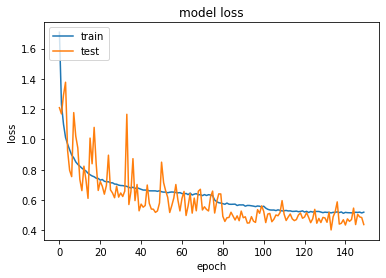

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()